# The nowcasting of economic conditions in Japan using machine learning

In [2]:
# Import packages
import re
import os
import sys
import requests
import MeCab
import oseti
import urllib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from math import sqrt
from bs4 import BeautifulSoup
from pathlib import Path
from subprocess import call
from keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose

from nltk.corpus import stopwords as sw       
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## Target variable: Indexes of Business Conditions (IBC)

The Index of Business Conditions (IBC) represents monthly economic conditions in Japan. This study uses either coincident index (level) or coincident ann (change from the previouse year: Year-over-Year) as a target variable.

In [3]:
ibc = pd.read_csv('data/Indexes of Business Conditions.csv')
ibc['Coincident ann'] = 100*ibc['Coincident Index'].pct_change(12)
ibc.tail()

,time,Coincident Index,Coincident ann
417,Oct-19,96.1,-7.596154
418,Nov-19,95.1,-7.128906
419,Dec-19,94.3,-6.910168
420,Jan-20,95.7,-5.059524
421,Feb-20,95.4,-6.286837


## Monthly Economic Report

The first data source for predictors is the text data in Monthly Economic Report from government of Japan.

### Web scraping

In [4]:
"""

# Get URLs of each report
content1 = requests.get('https://www5.cao.go.jp/keizai3/getsurei/kako_getsurei.html')
soup = BeautifulSoup(content1.text, 'html.parser')
tmp = str(soup.findAll(href=re.compile("main")))
pattern1 = "20[0-9]{2}/[0-9]{4}getsurei/main.pdf"
pattern2 = "20[0-9]{2}/[0-9]{4}getsurei/main.html"
url_list1 = re.findall(pattern1, tmp)
url_list2 = re.findall(pattern2, tmp)

content2 = requests.get('https://www5.cao.go.jp/keizai3/getsurei/getsurei-index.html')
soup = BeautifulSoup(content2.text, 'html.parser')
tmp = str(soup.findAll(href=re.compile("main")))
pattern3 = "20[0-9]{2}/[0-9]{4}getsurei/main.pdf"
url_list3 = re.findall(pattern3, tmp)

W = str()
for word in url_list1:
    W += str('https://www5.cao.go.jp/keizai3/getsurei/' + word + ' ')
url1 = W.split()
url1 = sorted(url1)

W = str()
for word in url_list2:
    W += str('https://www5.cao.go.jp/keizai3/getsurei/' + word + ' ')
url2 = W.split()
url2 = sorted(url2)

W = str()
for word in url_list3:
    W += str('https://www5.cao.go.jp/keizai3/getsurei/' + word + ' ')
url3 = W.split()
url3 = sorted(url3)

# Download reports as pdf foramt and transform them into dataframe
df1 = pd.DataFrame()
for i in range(0,105):
    urllib.request.urlretrieve(url1[i],'tmp.pdf')
    py_path = Path(sys.exec_prefix) / "Scripts" / "pdf2txt.py"
    call(["py", str(py_path), "-otmp.txt", "tmp.pdf"])
    tmp_data = open("tmp.txt", "r", encoding="utf-8")
    contents = tmp_data.read()
    contents = contents.replace('\n', '')
    contents = contents.replace('\x0c', '')
    contents = contents.replace(' ', '')
    tmp_time = url1[i].replace('https://www5.cao.go.jp/keizai3/getsurei/','')
    time = tmp_time.replace('getsurei/main.pdf','')
    tmp = pd.DataFrame([contents], index={time}, columns={'body'})
    df1 = df1.append(tmp)
    tmp_data.close()

df3 = pd.DataFrame()
for i in range(0,38):
    urllib.request.urlretrieve(url3[i],'tmp.pdf')
    py_path = Path(sys.exec_prefix) / "Scripts" / "pdf2txt.py"
    call(["py", str(py_path), "-otmp.txt", "tmp.pdf"])
    tmp_data = open("tmp.txt", "r", encoding="utf-8")
    contents = tmp_data.read()
    contents = contents.replace('\n', '')
    contents = contents.replace('\x0c', '')
    contents = contents.replace(' ', '')
    tmp_time = url3[i].replace('https://www5.cao.go.jp/keizai3/getsurei/','')
    time = tmp_time.replace('getsurei/main.pdf','')
    tmp = pd.DataFrame([contents], index={time}, columns={'body'})
    df3 = df3.append(tmp)
    tmp_data.close()

# Combine two parts of the text into one dataframe
dfm = pd.DataFrame()
dfm = dfm.append(df1)
dfm = dfm.append(df3)
dfm.to_csv("data/dfm.csv")

"""

'\n\n# Get URLs of each report\ncontent1 = requests.get(\'https://www5.cao.go.jp/keizai3/getsurei/kako_getsurei.html\')\nsoup = BeautifulSoup(content1.text, \'html.parser\')\ntmp = str(soup.findAll(href=re.compile("main")))\npattern1 = "20[0-9]{2}/[0-9]{4}getsurei/main.pdf"\npattern2 = "20[0-9]{2}/[0-9]{4}getsurei/main.html"\nurl_list1 = re.findall(pattern1, tmp)\nurl_list2 = re.findall(pattern2, tmp)\n\ncontent2 = requests.get(\'https://www5.cao.go.jp/keizai3/getsurei/getsurei-index.html\')\nsoup = BeautifulSoup(content2.text, \'html.parser\')\ntmp = str(soup.findAll(href=re.compile("main")))\npattern3 = "20[0-9]{2}/[0-9]{4}getsurei/main.pdf"\nurl_list3 = re.findall(pattern3, tmp)\n\nW = str()\nfor word in url_list1:\n    W += str(\'https://www5.cao.go.jp/keizai3/getsurei/\' + word + \' \')\nurl1 = W.split()\nurl1 = sorted(url1)\n\nW = str()\nfor word in url_list2:\n    W += str(\'https://www5.cao.go.jp/keizai3/getsurei/\' + word + \' \')\nurl2 = W.split()\nurl2 = sorted(url2)\n\nW = 

In [5]:
dfm = pd.read_csv("data/dfm.csv", index_col=0)
dfm.tail()

,body
2019/1018,（令和元年10月）－景気は、輸出を中心に弱さが長引いているものの、緩やかに回復している。－先...
2019/1122,（令和元年11月）－景気は、輸出を中心に弱さが長引いているものの、緩やかに回復している。－先...
2019/1220,（令和元年12月）－景気は、輸出が引き続き弱含むなかで、製造業を中心に弱さが一段と増している...
2020/0122,（令和２年１月）－景気は、輸出が引き続き弱含むなかで、製造業を中心に弱さが一段と増しているも...
2020/0220,（令和２年２月）－景気は、輸出が弱含むなかで、製造業を中心に弱さが一段と増した状態が続いてい...


### Pre-processing of text data

In [6]:
# Define the Morphological Analysis function for Japanese
# Extract only noun and verb (adjective and adjective verb)
def split_text(text):
    tagger = MeCab.Tagger()
    words = []
    for c in tagger.parse(text).splitlines()[:-1]:
        surface, feature = c.split('\t')
        pos = feature.split(',')[0]
        if pos=='名詞' or pos=='動詞': #pos=='形容詞' or pos=='形容動詞'
            words.append(surface)
    return ' '.join(words)

# Split texts in reports into words
split = pd.DataFrame()
for i in range(0,143):
    text = split_text(dfm.body[i])
    tmp = pd.DataFrame([text], index={dfm.index[i]}, columns={'body'})
    split = split.append(tmp)
    
# Eliminate useless words and adjust text size
clean = pd.DataFrame()
for i in range(0,143):
    text = re.sub('[いるなっところられ]+', '' , split.body[i]) #0-9１-９％円台年月日
    new_text = text[:round(len(text)*1)] # use 100% of text
    tmp = pd.DataFrame([new_text], index={dfm.index[i]}, columns={'body'})
    clean = clean.append(tmp)

### Create Words Cloud

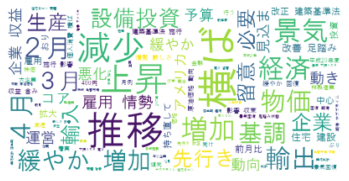

In [7]:
# Set up and draw the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white", 
                      font_path='HGRGM.TTC').generate(clean.body[0])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("images/wordcloud.png")

### Vectorize the text data

Use text vectors from economic reports as predictors

In [8]:
# TfidfVectorizer
vec_tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5, norm=None)
xform_tfidf = vec_tfidf.fit_transform(split.body).toarray()
col_names = vec_tfidf.get_feature_names()
xform_tfidf = pd.DataFrame(xform_tfidf, index=dfm.index, columns=col_names)

xform_tfidf.tail()

,00,00 25,00 25 範囲,00 する,00 する こと,00 据え置く,00 据え置く こと,000,000 上昇,000 上昇 いる,...,ｗｔｉ,ｗｔｉ 上昇,ｗｔｉ 上昇 金価格,ｗｔｉ 下落,ｗｔｉ 下落 金価格,ｗｔｉ 大幅,ｗｔｉ 大幅 上昇,ｗｔｉ 大幅 下落,ｗｔｉ 横ばい,ｗｔｉ 横ばい 推移
2019/1018,3.685358,0.0,0.0,0.0,0.0,2.01857,0.00000,4.115581,0.000000,0.0,...,1.527162,0.000000,0.000000,2.750937,2.791759,0.000000,0.0,0.000000,0.0,0.0
2019/1122,1.842679,0.0,0.0,0.0,0.0,2.01857,2.05779,0.000000,0.000000,0.0,...,1.527162,2.602517,2.602517,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
2019/1220,3.685358,0.0,0.0,0.0,0.0,2.01857,2.05779,0.000000,0.000000,0.0,...,1.527162,2.602517,2.602517,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
2020/0122,1.842679,0.0,0.0,0.0,0.0,2.01857,2.05779,4.115581,6.394449,0.0,...,1.527162,0.000000,0.000000,2.750937,2.791759,0.000000,0.0,0.000000,0.0,0.0
2020/0220,3.685358,0.0,0.0,0.0,0.0,2.01857,2.05779,0.000000,0.000000,0.0,...,1.527162,0.000000,0.000000,0.000000,0.000000,2.711717,0.0,3.330756,0.0,0.0


### Reduce dimensions by PCA

In [9]:
# Define PCA function
def iterate_var(var_target):
    var_fig = 0.0
    cnt = 1
    while var_fig <= var_target:
        pca = PCA(n_components=cnt)
        dim = pca.fit_transform(xform_tfidf)
        #dim = pca.fit_transform(xform_vec)
        var_fig = sum(pca.explained_variance_ratio_) 
        cnt += 1
    return dim, pca

# Set explained variance
dim, pca = iterate_var(0.5)
dim_m = pd.DataFrame(dim, index=dfm.index)

dim_m.tail()

,0,1,2,3,4,5,6,7,8
2019/1018,-85.950447,-29.157281,36.540503,162.427398,-3.292888,-30.555288,75.969369,-30.559765,6.404915
2019/1122,-83.417026,-8.148334,44.713648,172.159222,-4.800329,-34.146394,98.204333,-52.244580,11.804095
2019/1220,-84.704488,-3.345873,44.187720,170.648245,-6.757960,-36.209214,104.530249,-58.779516,12.792170
2020/0122,-85.696414,-3.327023,42.801606,162.813802,-5.237941,-35.851683,98.211738,-55.192602,7.366118
2020/0220,-80.762216,4.191598,35.270398,144.741203,-4.069603,-28.468821,88.114294,-48.878794,1.070273


### Time series analysis

In [10]:
# Set time series dataset
X = dim_m
y = ibc[279:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

,Coincident Index,Coincident ann,0,1,2,3,4,5,6,7,8
time,,,,,,,,,,,
2019-10-01,96.1,-7.596154,-85.950447,-29.157281,36.540503,162.427398,-3.292888,-30.555288,75.969369,-30.559765,6.404915
2019-11-01,95.1,-7.128906,-83.417026,-8.148334,44.713648,172.159222,-4.800329,-34.146394,98.204333,-52.244580,11.804095
2019-12-01,94.3,-6.910168,-84.704488,-3.345873,44.187720,170.648245,-6.757960,-36.209214,104.530249,-58.779516,12.792170
2020-01-01,95.7,-5.059524,-85.696414,-3.327023,42.801606,162.813802,-5.237941,-35.851683,98.211738,-55.192602,7.366118
2020-02-01,95.4,-6.286837,-80.762216,4.191598,35.270398,144.741203,-4.069603,-28.468821,88.114294,-48.878794,1.070273


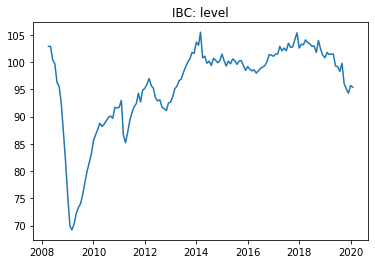

In [14]:
# Visualize y variable (level)
plt.plot(ts['Coincident Index'])
plt.title('IBC: level')
plt.savefig("images/ibc_level.png")

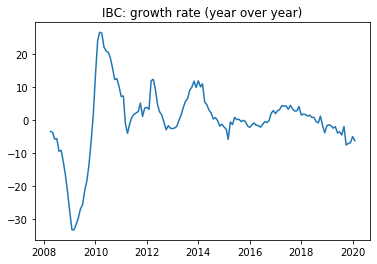

In [15]:
# Visualize y variable(YoY)
plt.plot(ts['Coincident ann'])
plt.title('IBC: growth rate (year over year)')
plt.savefig("images/ibc_ann.png")

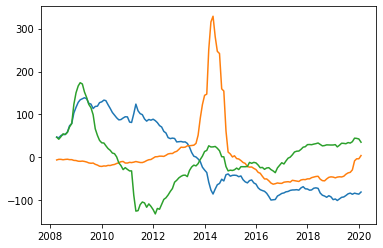

In [16]:
# visualize X variables
plt.plot(ts['0'])
plt.plot(ts['1'])
plt.plot(ts['2'])

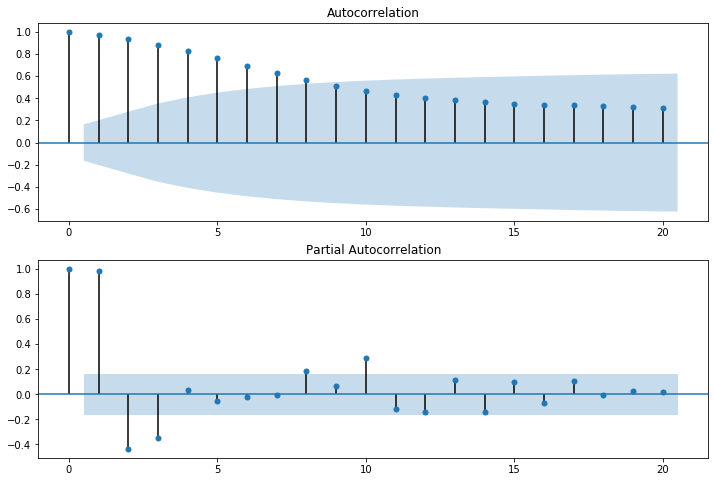

In [17]:
# Check Autocorrelation of y
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['Coincident Index'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['Coincident Index'], lags=20, ax=ax2)
plt.savefig("images/autocorrelation.png")

In [18]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['2'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['2'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['2'])
print("Cointegration test: {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.59
Unit root test (diff_y): 0.00
Unit root test (X): 0.37
Unit root test (diff_X): 0.00
Cointegration test: 0.74


### ARIMA Prediction

In [19]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:], order=(1,1,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  114
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -196.130
Date:                Thu, 14 May 2020   AIC                            416.260
Time:                        20:52:06   BIC                            448.988
Sample:                    04-01-2008   HQIC                           429.541
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0510      0.038     -1.355      0.175      -0.125       0.023
1             -0.0016      0.015     -0.106      0.916      -0.031       0.028
2             -0.0523      0.019     -2.767      0.0

Test set score: -0.50


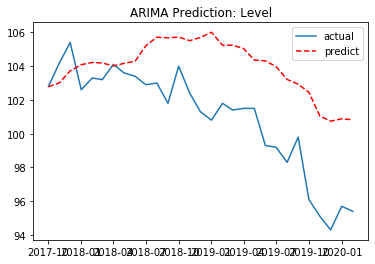

In [20]:
pred = SARIMAX.predict('2017-10-01', '2020-02-01', exog=test.iloc[:,2:])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('ARIMA Prediction: Level')
plt.savefig("images/text_level_arima.png")

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### ARIMA Prediction (Year-over-Year)

In [21]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident ann'], train.iloc[:,2:], order=(1,0,1), freq='MS').fit()
#SARIMAX = sm.tsa.SARIMAX(y_train, X_train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:         Coincident ann   No. Observations:                  114
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -261.674
Date:                Thu, 14 May 2020   AIC                            547.348
Time:                        20:52:08   BIC                            580.182
Sample:                    04-01-2008   HQIC                           560.674
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0079      0.019     -0.407      0.684      -0.046       0.030
1              0.0098      0.015      0.672      0.502      -0.019       0.038
2             -0.0817      0.021     -3.873      0.0

Test set score: 0.36


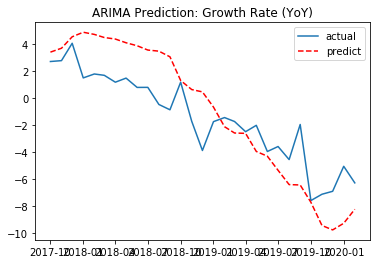

In [22]:
pred = SARIMAX.predict('2017-10-01', '2020-02-01', exog=test.iloc[:,2:])
plt.plot(test['Coincident ann'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend()
plt.title('ARIMA Prediction: Growth Rate (YoY)')
plt.savefig("images/text_yoy_arima.png")

print("Test set score: {:.2f}".format(r2_score(test['Coincident ann'], pred)))

### Random Forest

Training set score: 1.00
Cross-Validation score: 0.08
Test set score: 0.83


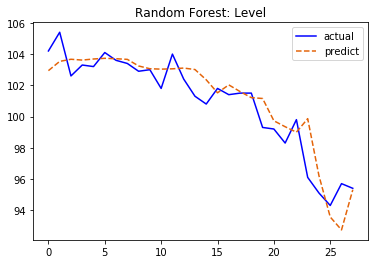

In [23]:
# Set X and y variables
X = dim_m
y = ibc['Coincident Index'][279:]
y.index = X.index

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/text_rf.png")

### RNN-LSTM

In [23]:
def multivariate_data(dataset, target, start_index, end_index, 
                      history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    # add current dataset
    indices = range(i-history_size, i+1, step)
    temp = pd.DataFrame(dataset[indices])
    # replace current target to previous one
    temp.iat[history_size, 0] = temp.iat[history_size-1, 0]
    data.append(np.array(temp))

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [24]:
def model_eval_metrics(y_true, y_pred, classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [21]:
# set features
temp = ibc.iloc[279:,1]
temp.index = dim_m.index
features = pd.concat([temp, dim_m], axis=1)
features.head()

,Coincident Index,0,1,2,3,4,5,6,7,8
time,,,,,,,,,,
Apr-08,102.9,47.215504,-6.061569,47.048140,5.523512,-52.157753,0.461583,-19.407146,44.628250,108.350910
May-08,102.9,45.488689,-4.585923,42.228971,6.178401,-57.268685,0.820559,-16.962207,45.942303,112.708531
Jun-08,100.4,50.832137,-4.651545,48.270689,9.346893,-62.437504,3.040909,-14.441996,46.346533,115.684850
Jul-08,99.7,52.990986,-5.571398,54.742805,11.854994,-62.267813,5.752368,-15.811514,46.170299,120.816353
Aug-08,96.3,53.271569,-4.797854,53.288753,15.429500,-62.331590,0.214929,-13.152230,40.144785,106.489477


In [22]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

114


In [23]:
# create training and test data
past_history = 1
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [25]:
# dataset
pd.DataFrame(dataset).head(5)

,0,1,2,3,4,5,6,7,8,9
0,1.044937,0.328679,-0.214619,0.827237,0.612486,-0.782385,0.023645,-0.660835,1.009695,2.341535
1,1.044937,0.306651,-0.195165,0.754715,0.629647,-0.868179,0.030251,-0.595492,1.038426,2.438305
2,0.743727,0.374813,-0.196030,0.845634,0.712675,-0.954945,0.071112,-0.528138,1.047264,2.504400
3,0.659388,0.402352,-0.208157,0.943031,0.778397,-0.952097,0.121011,-0.564740,1.043411,2.618356
4,0.249741,0.405931,-0.197959,0.921149,0.872064,-0.953167,0.019106,-0.493669,0.911667,2.300198


In [149]:
# X variables
pd.DataFrame(x_train_single[0])

,0,1,2,3,4,5,6,7,8,9
0,1.044937,0.328679,-0.214619,0.827234,0.612492,-0.782398,0.023637,-0.660645,1.009527,2.341740
1,1.044937,0.306651,-0.195165,0.754712,0.629652,-0.868193,0.030249,-0.595259,1.038297,2.438537


In [150]:
# y variable
y_train_single[0]

1.044937417729453

In [28]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [29]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128, input_shape=x_train_single.shape[-2:], return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
#single_step_model.add(tf.keras.layers.Flatten())
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae') #RMSprop Adam SGD

In [30]:
# train the model

single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200,
                                            validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 19s 93ms/step - loss: 0.3491 - val_loss: 0.1213
Epoch 2/10
200/200 [==============================] - 7s 37ms/step - loss: 0.1345 - val_loss: 0.1164
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1232 - val_loss: 0.1101
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.1164 - val_loss: 0.1046
Epoch 5/10
200/200 [==============================] - 4s 21ms/step - loss: 0.1128 - val_loss: 0.1073
Epoch 6/10
200/200 [==============================] - 7s 35ms/step - loss: 0.1078 - val_loss: 0.1051
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1049 - val_loss: 0.0925
Epoch 8/10
200/200 [==============================] - 4s 21ms/step - loss: 0.1022 - val_loss: 0.1087
Epoch 9/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0996 - val_loss: 0.0914
Epoch 10/10
200/200 [==========================

In [31]:
# evaluate the model

model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.015221,0.123374,0.096327,0.888299


Test set score: 0.89


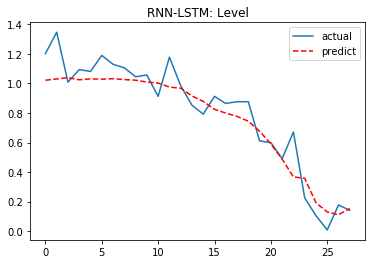

In [32]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/text_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

## Sentiment index analysis

Use a sentiment score from economic reports as predictors

In [24]:
# https://qiita.com/yukinoi/items/46aa016d83bb0e64f598
sentiment = oseti.Analyzer()

# create sentiment index for economic reports
sent = pd.DataFrame()
for i in range(0,143):
    sen = pd.DataFrame(sentiment.count_polarity(split.body[i]))
    pos = sum(sen.positive)
    neg = sum(sen.negative)
    score = (pos-neg)/(pos+neg)
    tmp1 = pd.DataFrame([pos], index={clean.index[i]}, columns={'positive'})
    tmp2 = pd.DataFrame([neg], index={clean.index[i]}, columns={'negative'})
    tmp3 = pd.DataFrame([score], index={clean.index[i]}, columns={'sentiment'})
    tmp = pd.concat([tmp1, tmp2, tmp3], axis=1)
    sent = sent.append(tmp)

# create dataset
y = ibc[279:]
y = y.set_index('time')
sent.index = y.index
ts = pd.concat([y, sent], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

,Coincident Index,Coincident ann,positive,negative,sentiment
time,,,,,
2019-10-01,96.1,-7.596154,180.0,90.0,0.333333
2019-11-01,95.1,-7.128906,188.0,99.0,0.310105
2019-12-01,94.3,-6.910168,184.0,86.0,0.362963
2020-01-01,95.7,-5.059524,188.0,71.0,0.451737
2020-02-01,95.4,-6.286837,203.0,96.0,0.357860


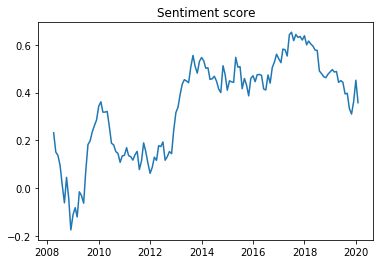

In [25]:
# visualize sentiment index
plt.plot(ts.sentiment)
plt.title('Sentiment score')
plt.savefig("images/sentiment.png")

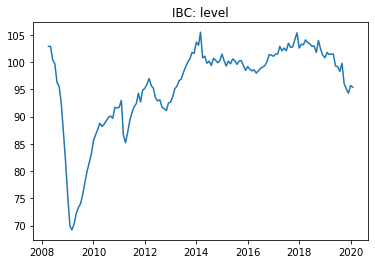

In [26]:
# visualize IBC (level)
plt.plot(ts['Coincident Index'])
plt.title('IBC: level')
plt.savefig("images/ibc_level.png")

In [27]:
# Check correlation
print("<Sentiment Score>")
cor = ts['Coincident Index'].corr(ts.sentiment)
print("Correlation of level: {:.2f}".format(cor))
sent_ann = 100*ts.sentiment.pct_change(12)
cor = ts['Coincident ann'].corr(sent_ann)
print("Correlation of YoY: {:.2f}".format(cor))

print("<Positive Score>")
cor = ts['Coincident Index'].corr(ts.positive)
print("Correlation of level: {:.2f}".format(cor))
sent_ann = 100*ts.positive.pct_change(12)
cor = ts['Coincident ann'].corr(sent_ann)
print("Correlation of YoY: {:.2f}".format(cor))

print("<Negative Score>")
cor = ts['Coincident Index'].corr(ts.negative)
print("Correlation of level: {:.2f}".format(cor))
sent_ann = 100*ts.negative.pct_change(12)
cor = ts['Coincident ann'].corr(sent_ann)
print("Correlation of YoY: {:.2f}".format(cor))

<Sentiment Score>
Correlation of level: 0.77
Correlation of YoY: -0.34
<Positive Score>
Correlation of level: 0.52
Correlation of YoY: 0.23
<Negative Score>
Correlation of level: -0.72
Correlation of YoY: -0.40


### Time series analysis

In [28]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['sentiment'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['sentiment'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['sentiment'])
print("Cointegration test (sentiment): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['positive'])
print("Cointegration test (positive): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['negative'])
print("Cointegration test (negative): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.59
Unit root test (diff_y): 0.00
Unit root test (X): 0.34
Unit root test (diff_X): 0.00
Cointegration test (sentiment): 0.00
Cointegration test (positive): 0.23
Cointegration test (negative): 0.05


### ARIMA Prediction

In [29]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,4:], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  114
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -221.622
Date:                Thu, 14 May 2020   AIC                            451.244
Time:                        20:54:17   BIC                            462.189
Sample:                    04-01-2008   HQIC                           455.686
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      2.8195      2.506      1.125      0.261      -2.092       7.731
ar.L1          0.9998      0.003    358.536      0.000       0.994       1.005
ma.L1          0.2419      0.064      3.766      0.0

Test set score: 0.17


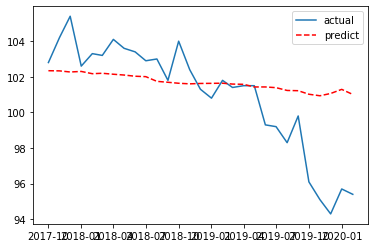

In [30]:
pred = SARIMAX.predict('2017-10-01', '2020-02-01', exog=test.iloc[:,4:])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.33
Test set score: 0.83


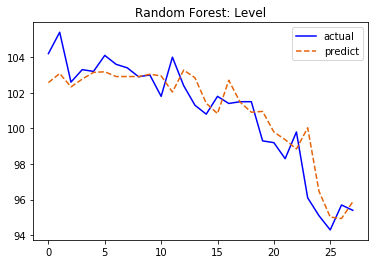

In [31]:
# Set X and y variables
X = ts.iloc[:,4:]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/sentiment_rf.png")

### RNN-LSTM

In [71]:
# set dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,4:]], axis=1)
features.tail()

,Coincident Index,sentiment
time,,
2019-10-01,96.1,0.333333
2019-11-01,95.1,0.310105
2019-12-01,94.3,0.362963
2020-01-01,95.7,0.451737
2020-02-01,95.4,0.357860


In [72]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

114


In [73]:
past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [74]:
pd.DataFrame(dataset).head(7)

,0,1
0,1.044937,-0.373717
1,1.044937,-0.770859
2,0.743727,-0.846016
3,0.659388,-1.047957
4,0.249741,-1.465408
5,0.153353,-1.827247
6,-0.220148,-1.298985


In [75]:
pd.DataFrame(x_train_single[0])

,0,1
0,1.044937,-0.373717
1,1.044937,-0.770859
2,0.743727,-0.846016
3,0.659388,-1.047957
4,0.249741,-1.465408
5,0.153353,-1.827247
6,0.153353,-1.298985


In [76]:
y_train_single[0]

-0.22014813807327502

In [77]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [78]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.LSTM(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
#single_step_model.add(tf.keras.layers.Flatten())
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [79]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200,
                                            validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 23ms/step - loss: 0.4355 - val_loss: 0.1979
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2080 - val_loss: 0.1559
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1362 - val_loss: 0.1281
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1081 - val_loss: 0.1216
Epoch 5/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0913 - val_loss: 0.1121
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0852 - val_loss: 0.1061
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0806 - val_loss: 0.1007
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0796 - val_loss: 0.1074
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0799 - val_loss: 0.1070
Epoch 10/10
200/200 [==============================] -

In [80]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.016474,0.128351,0.102025,0.875254


Test set score: 0.88


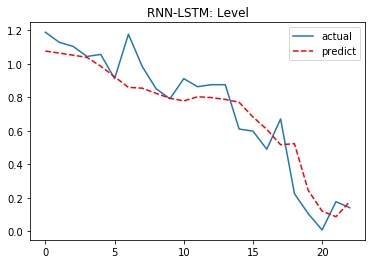

In [81]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/sentiment_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

## Google Trend

Use google trend information as predictors

In [32]:
# Import packages
from pytrends.request import TrendReq
plt.rcParams['font.family'] = 'IPAexGothic'

# API Connection
pytrends = TrendReq(hl='ja-JP', tz=360)

Correlation of level: -0.90
Correlation of YoY: -0.67


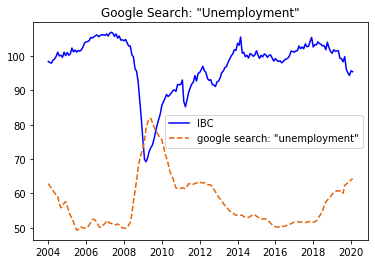

In [69]:
# Set keyword ("失業" = "unemployment")
# kw_list = ["失業"]
# pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
# gt1 = pytrends.interest_over_time()
# gt1 = gt1.rename(columns = {"失業": "unemployment", "isPartial": "info"})
# gt1.to_csv("data/gt1.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt1 = pd.read_csv('data/gt1.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s1 = seasonal_decompose(gt1.iloc[:,0], extrapolate_trend='freq')
t1 = s1.trend

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t1.index
cor = level.corr(t1)
print("Correlation of level: {:.2f}".format(cor))

a1 = gt1.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a1.index
cor = ann.corr(a1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t1.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t1.index, t1, linestyle='--', color='#e46409', label='google search: "unemployment"')
ax.legend()
plt.title('Google Search: "Unemployment"')
plt.savefig("images/google1.png")

Correlation of level: 0.65
Correlation of YoY: 0.22


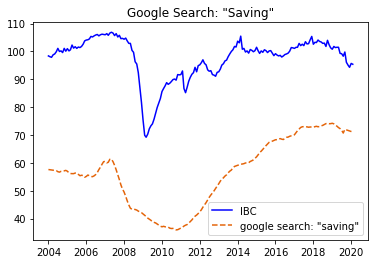

In [34]:
# Set keyword ("貯金" = "saving")
# kw_list = ["貯金"]
# pytrends.build_payload(kw_list, timeframe='2004-01-01 2020-02-29', geo='JP')
# gt2 = pytrends.interest_over_time()
# gt2 = gt2.rename(columns = {"貯金": "saving", "isPartial": "info"})
# gt2.to_csv("data/gt2.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
gt2 = pd.read_csv('data/gt2.csv', index_col=0, date_parser=dateparse, dtype='float')

# Extract trend factor
s2 = seasonal_decompose(gt2.iloc[:,0], extrapolate_trend='freq')
t2 = s2.trend

# Check correlation
level = ibc['Coincident Index'][228:]
level.index = t2.index
cor = level.corr(t2)
print("Correlation of level: {:.2f}".format(cor))

a2 = gt2.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][228:]
ann.index = a2.index
cor = ann.corr(a2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t2.index, ibc['Coincident Index'][228:], linestyle='-', color='b', label='IBC')
ax.plot(t2.index, t2, linestyle='--', color='#e46409', label='google search: "saving"')
ax.legend()
plt.title('Google Search: "Saving"')
plt.savefig("images/google2.png")

In [35]:
# Combine google trend (level)
gtrend_l = pd.concat([t1, t2], axis=1)

# Combine google trend (YoY)
gtrend_y = pd.concat([a1, a2], axis=1)
#gtrend_y = gtrend_y.drop(gtrend_y.index[0:12])

### Time series analysis

In [36]:
# Set time series dataset
X = pd.concat([gtrend_l, gtrend_y], axis=1)
y = ibc[228:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

,Coincident Index,Coincident ann,unemployment,saving,unemployment.1,saving.1
time,,,,,,
2019-10-01,96.1,-7.596154,62.732712,71.836636,0.000000,-0.090909
2019-11-01,95.1,-7.128906,63.122426,71.642580,-0.032787,-0.084507
2019-12-01,94.3,-6.910168,63.512141,71.448524,0.102041,-0.041667
2020-01-01,95.7,-5.059524,63.901855,71.254468,-0.085714,-0.127907
2020-02-01,95.4,-6.286837,64.291570,71.060412,-0.148649,-0.171053


In [37]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['unemployment'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['unemployment'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['unemployment'])
print("Cointegration test (unemployment): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['saving'])
print("Cointegration test (saving): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.11
Unit root test (diff_y): 0.00
Unit root test (X): 0.27
Unit root test (diff_X): 0.02
Cointegration test (unemployment): 0.01
Cointegration test (saving): 0.07


### ARIMA Prediction

In [38]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:3], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  155
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -274.845
Date:                Thu, 14 May 2020   AIC                            557.690
Time:                        20:55:10   BIC                            569.864
Sample:                    01-01-2004   HQIC                           562.635
                         - 11-01-2016                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment    -0.5512      0.122     -4.506      0.000      -0.791      -0.311
ar.L1            0.9999      0.001    792.151      0.000       0.997       1.002
ma.L1            0.1539      0.063      2.42

Test set score: -0.44


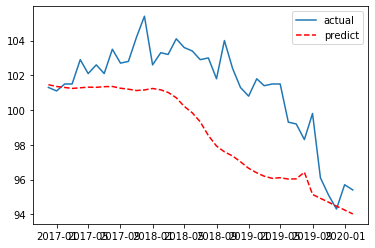

In [39]:
pred = SARIMAX.predict('2016-12-01', '2020-02-01', exog=test.iloc[:,2:3])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### Random Forest

Training set score: 0.99
Cross-Validation score: 0.05
Test set score: 0.78


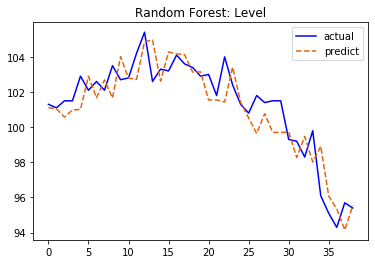

In [40]:
# Set X and y variables
X = ts.iloc[:,2:3]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/google_rf.png")

### RNN-LSTM

In [61]:
# set the dataset
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:3]], axis=1)
features.head()

,Coincident Index,unemployment
time,,
2004-01-01,98.4,62.841249
2004-02-01,98.1,62.176913
2004-03-01,97.9,61.512578
2004-04-01,98.8,60.848242
2004-05-01,99.1,60.183906


In [62]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(features))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

155


In [63]:
# create the training and test data

past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [64]:
pd.DataFrame(dataset).head(7)

,0,1
0,0.208363,0.585938
1,0.172372,0.505991
2,0.148378,0.426043
3,0.256352,0.346096
4,0.292343,0.266148
5,0.388320,0.186201
6,0.532286,0.153760


In [65]:
pd.DataFrame(x_train_single[0])

,0,1
0,0.208363,0.585938
1,0.172372,0.505991
2,0.148378,0.426043
3,0.256352,0.346096
4,0.292343,0.266148
5,0.388320,0.186201
6,0.388320,0.153760


In [66]:
y_train_single[0]

0.532286039253948

In [67]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [68]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train_single.shape[-2:]))
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mae')

In [69]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200,
                                            validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 17ms/step - loss: 0.8834 - val_loss: 0.3773
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.7035 - val_loss: 0.2658
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.5464 - val_loss: 0.1460
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4634 - val_loss: 0.1317
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4069 - val_loss: 0.1616
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3606 - val_loss: 0.1842
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3273 - val_loss: 0.1797
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3025 - val_loss: 0.1590
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2837 - val_loss: 0.1477
Epoch 10/10
200/200 [==============================] - 1

In [70]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.016294,0.127648,0.099905,0.865667


Test set score: 0.87


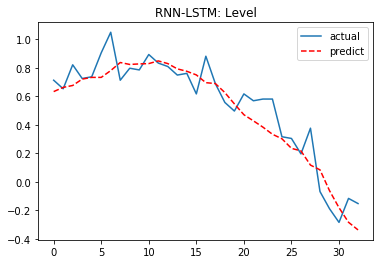

In [71]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/google_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

## Electricity usage

Use electricity usage as predictors. The data up to 2016 is available on the Federation of Electric Power Companies (FEPC). For the data after 2016, it is needed to extract the data from 10 regional companies' websites. 

### Electricity usage data up to 2016 (FEPC)

In [41]:
past = pd.read_csv("data/electricity/past_elec.csv", index_col=0, parse_dates=True)
past.tail()

,total,manufac,home,hokkaido,touhoku,tokyo,cyubu,hokuriku,kansai,cyugoku,shikoku,kyushu,okinawa
date,,,,,,,,,,,,,
2015-11-01,60716671,20925883,39790788,1957471,3770970,12635365,5267052,1221189,6348491,2538923,1325099,4171917,554311
2015-12-01,63604246,20599296,43004950,2037416,4337510,14039592,5478028,1451686,6592122,2808292,1457393,4308727,494184
2016-01-01,73205156,20441436,52763720,2629883,5181720,16404146,6879849,1822099,8437918,3423528,1842317,5631231,511029
2016-02-01,72899139,20273742,52625397,2406565,5189185,17345157,6763051,1732640,8009869,3476379,1720426,5500944,481181
2016-03-01,69545218,21053124,48492094,2348201,4829178,15615407,6283345,1621908,7497503,3198588,1652053,4982600,463311


In [42]:
# Extract trend factor (Total)
sea = seasonal_decompose(past.iloc[:,0], extrapolate_trend='freq')
tt1 = sea.trend
#plt.plot(tt1)

Correlation of level: 0.05
Correlation of YoY: 0.45


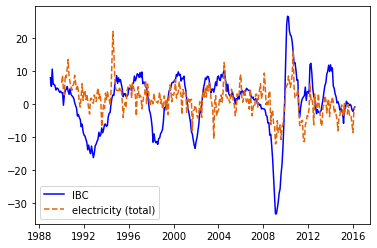

In [43]:
# Check correlation (Total)
level = ibc['Coincident Index'][48:375]
level.index = tt1.index
cor = level.corr(tt1)
print("Correlation of level: {:.2f}".format(cor))

aa1 = 100*past.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa1.index
cor = ann.corr(aa1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa1.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa1.index, aa1, linestyle='--', color='#e46409', label='electricity (total)')
ax.legend(loc='best')
plt.savefig("images/total.png")

In [44]:
# Extract trend factor (Manufacture)
sea = seasonal_decompose(past.iloc[:,1], extrapolate_trend='freq')
tt2 = sea.trend
#plt.plot(tt2)

Correlation of level: 0.32
Correlation of YoY: 0.80


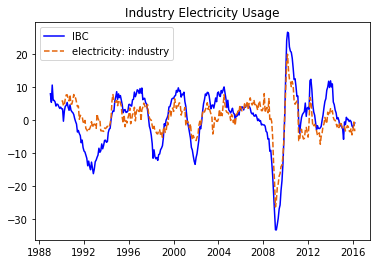

In [45]:
# Check correlation (Manufacture)
level = ibc['Coincident Index'][48:375]
level.index = tt2.index
cor = level.corr(tt2)
print("Correlation of level: {:.2f}".format(cor))

aa2 = 100*past.iloc[:,1].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa2.index
cor = ann.corr(aa2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa2.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa2.index, aa2, linestyle='--', color='#e46409', label='electricity: industry')
ax.legend(loc='best')
plt.title('Industry Electricity Usage')
plt.savefig("images/manufacture2016.png")

In [46]:
# Extract trend factor (Household)
sea = seasonal_decompose(past.iloc[:,2], extrapolate_trend='freq')
tt3 = sea.trend
#plt.plot(tt3)

Correlation of level: -0.01
Correlation of YoY: 0.19


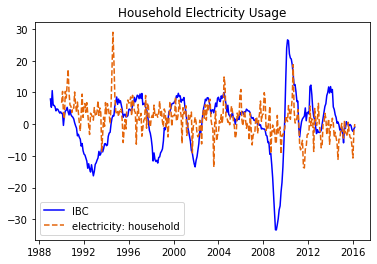

In [47]:
# Check correlation (Household)
level = ibc['Coincident Index'][48:375]
level.index = tt3.index
cor = level.corr(tt3)
print("Correlation of level: {:.2f}".format(cor))

aa3 = 100*past.iloc[:,2].pct_change(12)
ann = ibc['Coincident ann'][48:375]
ann.index = aa3.index
cor = ann.corr(aa3)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aa3.index, ibc['Coincident ann'][48:375], linestyle='-', color='b', label='IBC')
ax.plot(aa3.index, aa3, linestyle='--', color='#e46409', label='electricity: household')
ax.legend(loc='best')
plt.title('Household Electricity Usage')
plt.savefig("images/home2016.png")

### Time series analysis

In [48]:
# Set time series dataset
X = pd.concat([tt2, tt3, aa2, aa3], axis=1)[12:]
y = ibc[60:375]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

,Coincident Index,Coincident ann,manufac,home,manufac.1,home.1
time,,,,,,
2015-11-01,99.4,-0.500501,2.124208e+07,4.509874e+07,-2.555059,-4.382219
2015-12-01,98.5,-1.794616,2.119000e+07,4.496826e+07,-4.521196,-7.125220
2016-01-01,99.2,-2.266010,2.113792e+07,4.483778e+07,-3.165219,-10.679996
2016-02-01,98.7,-1.497006,2.108585e+07,4.470730e+07,-0.606093,-2.172183
2016-03-01,98.4,-0.906344,2.103377e+07,4.457683e+07,-3.410622,0.055157


In [49]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['manufac'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['manufac'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['manufac'])
print("Cointegration test (manufac): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['home'])
print("Cointegration test (home): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.01
Unit root test (diff_y): 0.00
Unit root test (X): 0.36
Unit root test (diff_X): 0.00
Cointegration test (manufac): 0.23
Cointegration test (home): 0.03


### ARIMA Prediction

In [50]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -346.650
Date:                Thu, 14 May 2020   AIC                            703.301
Time:                        20:56:08   BIC                            720.928
Sample:                    01-01-1990   HQIC                           710.394
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac     7.864e-06   4.57e-07     17.214      0.000    6.97e-06    8.76e-06
home       -1.165e-06   4.75e-07     -2.452      0.014    -2.1e-06   -2.34e-07
ar.L1          0.3431      0.326      1.053      0.2

C:\Users\roomr\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test set score: -5.21


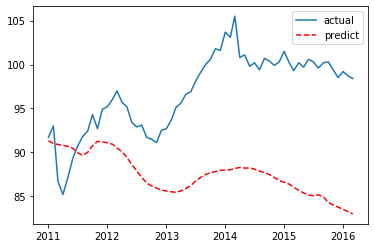

In [51]:
pred = SARIMAX.predict('2011-01-01', '2016-03-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### ARIMA Prediction (YoY)

In [52]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident ann'], train.iloc[:,4:], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:         Coincident ann   No. Observations:                  252
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -477.120
Date:                Thu, 14 May 2020   AIC                            964.240
Time:                        20:56:10   BIC                            981.887
Sample:                    01-01-1990   HQIC                           971.341
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac.1      0.5417      0.042     12.790      0.000       0.459       0.625
home.1        -0.0072      0.023     -0.312      0.755      -0.052       0.038
ar.L1          0.9648      0.016     60.294      0.0

Test set score: 0.41


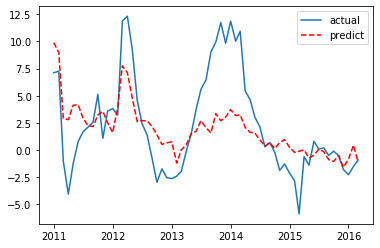

In [53]:
pred = SARIMAX.predict('2011-01-01', '2016-03-01', exog=test.iloc[:,4:])
plt.plot(test['Coincident ann'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident ann'], pred)))

### Random Forest

Training set score: 1.00
Cross-Validation score: 0.92
Test set score: 0.86


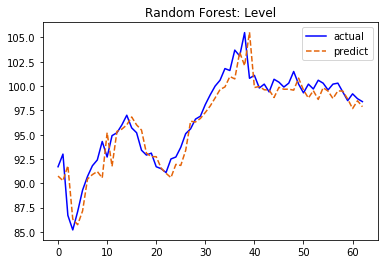

In [54]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/elect_rf.png")

### RNN-LSTM

In [261]:
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.head()

,Coincident Index,manufac,home
time,,,
1990-01-01,104.0,1.980151e+07,3.229751e+07
1990-02-01,104.1,1.991798e+07,3.272567e+07
1990-03-01,104.1,2.001871e+07,3.313942e+07
1990-04-01,104.6,2.013104e+07,3.336801e+07
1990-05-01,105.7,2.023419e+07,3.351295e+07


In [262]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(ts))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

252


In [263]:
# create the training and test data

past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [264]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,1.292866,-1.759714,-2.263530
1,1.303994,-1.663543,-2.187202
2,1.303994,-1.580362,-2.113446
3,1.359634,-1.487607,-2.072697
4,1.482040,-1.402429,-2.046859
5,1.571064,-1.337302,-2.026243
6,1.615575,-1.265267,-2.003367


In [265]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,1.292866,-1.759714,-2.263530
1,1.303994,-1.663543,-2.187202
2,1.303994,-1.580362,-2.113446
3,1.359634,-1.487607,-2.072697
4,1.482040,-1.402429,-2.046859
5,1.571064,-1.337302,-2.026243
6,1.571064,-1.265267,-2.003367


In [266]:
y_train_single[0]

1.6155751333533248

In [267]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [268]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4, input_shape=x_train_single.shape[-2:])) #return_sequences=True 
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(8, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [269]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200, 
                                            validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 0.6256 - val_loss: 0.1753
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.3397 - val_loss: 0.1317
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2327 - val_loss: 0.1257
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1715 - val_loss: 0.1136
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1371 - val_loss: 0.1052
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1160 - val_loss: 0.0985
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1060 - val_loss: 0.0936
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0981 - val_loss: 0.0903
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0926 - val_loss: 0.0902
Epoch 10/10
200/200 [==============================] - 1

In [270]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.013812,0.117524,0.089741,0.914851


Test set score: 0.91


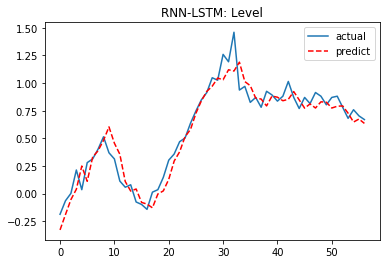

In [271]:
# visualize the result

plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/elect_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))

### Electricity usage data after 2016 (10 regional electricity companies)

In [55]:
all = pd.read_csv("data/electricity/all_elec.csv", index_col=0, parse_dates=True)
all.tail()

,total,manufac,home,manu/tot,hokkaido,touhoku,tokyo,cyubu,hokuriku,kansai,cyugoku,shikoku,kyushu,okinawa
date,,,,,,,,,,,,,,
2019-10-01,61049334,21445570,39603765,0.351283,2310263,6105910,21895980,10456171,2192666,11066220,4674528.0,2136900,6571589,720739
2019-11-01,61150393,20815409,40334984,0.340397,2588457,6538410,21961360,10278030,2286570,10772939,4746639.0,2101400,6368962,600980
2019-12-01,70448565,22429886,48018679,0.318387,3070698,7537130,25566860,11456472,2594920,12440043,5499171.0,2400560,7467543,587096
2020-01-01,71962170,19536414,52425757,0.271482,3138465,7760140,26228480,11746264,2653126,12649978,5519369.0,2429270,7609594,574988
2020-02-01,68073124,18764669,49308455,0.275655,2945058,7388070,23946550,11484744,2619241,12281023,5282637.0,2333920,7140795,547466


In [56]:
# Extract trend factor (Total)
sea = seasonal_decompose(all.iloc[:,0], extrapolate_trend='freq')
ttt1 = sea.trend
#plt.plot(tt1)

Correlation of level: 0.05
Correlation of YoY: 0.44


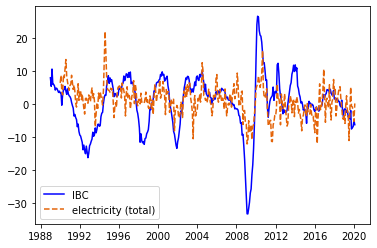

In [57]:
# Check correlation (Total)
level = ibc['Coincident Index'][48:]
level.index = ttt1.index
cor = level.corr(ttt1)
print("Correlation of level: {:.2f}".format(cor))

aaa1 = 100*all.iloc[:,0].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa1.index
cor = ann.corr(aaa1)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa1.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa1.index, aaa1, linestyle='--', color='#e46409', label='electricity (total)')
ax.legend(loc='best')

In [58]:
# Extract trend factor (Manufacture)
sea = seasonal_decompose(all.iloc[:,1], extrapolate_trend='freq')
ttt2 = sea.trend
#plt.plot(tt2)

Correlation of level: 0.25
Correlation of YoY: 0.77


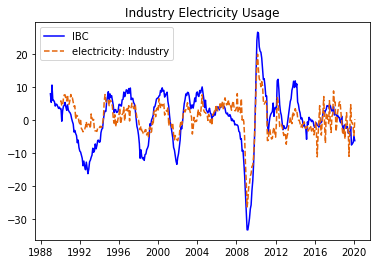

In [59]:
# Check correlation (Manufacture)
level = ibc['Coincident Index'][48:]
level.index = ttt2.index
cor = level.corr(ttt2)
print("Correlation of level: {:.2f}".format(cor))

aaa2 = 100*all.iloc[:,1].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa2.index
cor = ann.corr(aaa2)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa2.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa2.index, aaa2, linestyle='--', color='#e46409', label='electricity: Industry')
ax.legend(loc='best')
plt.title('Industry Electricity Usage')
plt.savefig("images/manufacture_all.png")

In [60]:
# Extract trend factor (Household)
sea = seasonal_decompose(all.iloc[:,2], extrapolate_trend='freq')
ttt3 = sea.trend
#plt.plot(tt3)

Correlation of level: 0.00
Correlation of YoY: 0.19


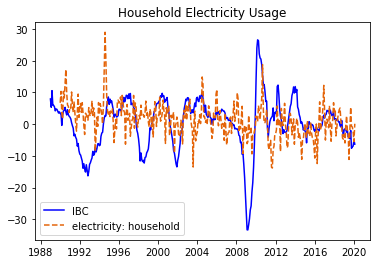

In [61]:
# Check correlation (Household)
level = ibc['Coincident Index'][48:]
level.index = ttt3.index
cor = level.corr(ttt3)
print("Correlation of level: {:.2f}".format(cor))

aaa3 = 100*all.iloc[:,2].pct_change(12)
ann = ibc['Coincident ann'][48:]
ann.index = aaa3.index
cor = ann.corr(aaa3)
print("Correlation of YoY: {:.2f}".format(cor))

# Plot trend
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(aaa3.index, ibc['Coincident ann'][48:], linestyle='-', color='b', label='IBC')
ax.plot(aaa3.index, aaa3, linestyle='--', color='#e46409', label='electricity: household')
ax.legend(loc='best')
plt.title('Household Electricity Usage')
plt.savefig("images/home_all.png")

### Time series analysis

In [62]:
# Set time series dataset
X = pd.concat([ttt2, ttt3, aaa2, aaa3], axis=1)[12:]
y = ibc[60:]
y = y.set_index('time')
X.index = y.index
ts = pd.concat([y, X], axis=1)
ts.to_csv("ts.csv")
dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
ts = pd.read_csv('ts.csv', index_col=0, date_parser=dateparse, dtype='float')

# Split data into training and test set 
sp = round(0.8*len(ts))
train = ts[0:sp]
test = ts[sp:]

ts.tail()

,Coincident Index,Coincident ann,manufac,home,manufac.1,home.1
time,,,,,,
2019-10-01,96.1,-7.596154,2.087500e+07,4.467359e+07,-0.787200,-0.658240
2019-11-01,95.1,-7.128906,2.083051e+07,4.459382e+07,-0.881591,-0.882650
2019-12-01,94.3,-6.910168,2.078602e+07,4.451404e+07,-2.182011,-2.231194
2020-01-01,95.7,-5.059524,2.074152e+07,4.443427e+07,-4.688206,-5.477887
2020-02-01,95.4,-6.286837,2.069703e+07,4.435449e+07,0.204182,0.131469


In [63]:
# Unit root test of y (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['Coincident Index'])
print("Unit root test (y): {:.2f}".format(adf_result[1])) # p-value

# Take difference of y
diff = ts['Coincident Index'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_y): {:.2f}".format(adf_result[1])) # p-value

# Unit root test of X (H0: non-stationary)
adf_result = sm.tsa.stattools.adfuller(ts['manufac'])
print("Unit root test (X): {:.2f}".format(adf_result[1])) # p-value

# Take difference of X
diff = ts['manufac'].diff()
diff = diff.dropna()
adf_result = sm.tsa.stattools.adfuller(diff)
print("Unit root test (diff_X): {:.2f}".format(adf_result[1])) # p-value

# Cointegration test (H0: non-cointegration)
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['manufac'])
print("Cointegration test (manufac): {:.2f}".format(coint_result[1])) # p-value
coint_result = sm.tsa.stattools.coint(ts['Coincident Index'], ts['home'])
print("Cointegration test (home): {:.2f}".format(coint_result[1])) # p-value

Unit root test (y): 0.01
Unit root test (diff_y): 0.00
Unit root test (X): 0.36
Unit root test (diff_X): 0.00
Cointegration test (manufac): 0.27
Cointegration test (home): 0.02


### ARIMA Prediction

In [64]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident Index'], train.iloc[:,2:4], order=(1,1,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:       Coincident Index   No. Observations:                  290
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -425.388
Date:                Thu, 14 May 2020   AIC                            860.777
Time:                        20:57:12   BIC                            879.109
Sample:                    01-01-1990   HQIC                           868.122
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac     7.646e-06   5.15e-07     14.840      0.000    6.64e-06    8.66e-06
home       -8.174e-07    3.4e-07     -2.401      0.016   -1.48e-06    -1.5e-07
ar.L1          0.3569      0.359      0.995      0.3

C:\Users\roomr\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test set score: -0.68


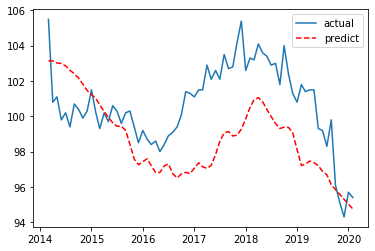

In [65]:
pred = SARIMAX.predict('2014-03-01', '2020-02-01', exog=test.iloc[:,2:4])
plt.plot(test['Coincident Index'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident Index'], pred)))

### ARIMA Prediction (YoY)

In [66]:
# Fit the model
SARIMAX = sm.tsa.SARIMAX(train['Coincident ann'], train.iloc[:,4:6], order=(1,0,1), freq='MS').fit()
print(SARIMAX.summary())

                           Statespace Model Results                           
Dep. Variable:         Coincident ann   No. Observations:                  290
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -562.038
Date:                Thu, 14 May 2020   AIC                           1134.076
Time:                        20:57:13   BIC                           1152.425
Sample:                    01-01-1990   HQIC                          1141.427
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
manufac.1      0.5775      0.036     16.114      0.000       0.507       0.648
home.1         0.0043      0.024      0.181      0.856      -0.042       0.051
ar.L1          0.9630      0.015     62.202      0.0

Test set score: -0.46


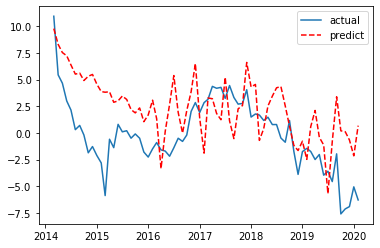

In [67]:
pred = SARIMAX.predict('2014-03-01', '2020-02-01', exog=test.iloc[:,4:6])
plt.plot(test['Coincident ann'], label="actual")
plt.plot(pred, "r", linestyle='--', label="predict")
plt.legend(loc='best')

print("Test set score: {:.2f}".format(r2_score(test['Coincident ann'], pred)))

### Random Forest

Training set score: 1.00
Cross-Validation score: 0.92
Test set score: 0.69


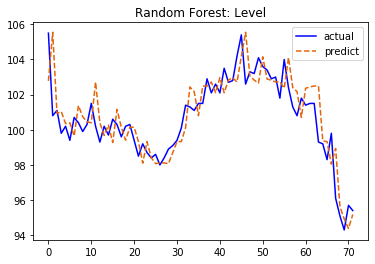

In [68]:
# Set X and y variables
X = ts.iloc[:,2:4]
y = ts['Coincident Index']

# Preprocess for adding AR
X_l = X.drop(X.index[0])
#X_l = X_l.drop(X_l.index[0])
X_l.reset_index(inplace=True, drop=True)

# Generate AR variable
y_l = y.drop(y.index[-1])
#y_l = y_l.drop(y_l.index[-1])
y_l.reset_index(inplace=True, drop=True)

# Add AR into X
X_t = pd.concat([y_l, X_l], axis=1)
y_t = y.drop(y.index[0])
#y_t = y_t.drop(y_t.index[0])
X_t.index = y_t.index

# Split data into training and test set 
sp = round(0.8*len(X_t))
X_train = X_t[0:sp]
X_test = X_t[sp:]
y_train = y_t[0:sp]
y_test = y_t[sp:]

# Fit the model
tm = RandomForestRegressor(n_estimators=1000).fit(X_train, y_train)
#tm.feature_importances_

# Goodness of Fit
print("Training set score: {:.2f}".format(tm.score(X_train, y_train)))
print("Cross-Validation score: {:.2f}".format(
          np.mean(cross_val_score(tm, X_train, y_train, cv=5))))
print("Test set score: {:.2f}".format(tm.score(X_test, y_test)))

# Calculate the prediction
prediction = pd.DataFrame(tm.predict(X_test))
pre = prediction.values.tolist()
act = y_test.values.tolist()
predict = pd.DataFrame(pre, columns=['predict'])
actual = pd.DataFrame(act, columns=['actual'])
com = pd.concat([predict, actual], axis=1)

# Plot the prediction
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(com.index, com.actual, linestyle='-', color='b', label='actual')
ax.plot(com.index, com.predict, linestyle='--', color='#e46409', label='predict')
ax.legend(loc='best')
ax.set_title('Random Forest: Level')
plt.savefig("images/elec_all_rf.png")

### RNN-LSTM

In [461]:
features = pd.concat([ts['Coincident Index'], ts.iloc[:,2:4]], axis=1)
features.tail()

,Coincident Index,manufac,home
time,,,
2019-10-01,96.1,2.087500e+07,4.467359e+07
2019-11-01,95.1,2.083051e+07,4.459382e+07
2019-12-01,94.3,2.078602e+07,4.451404e+07
2020-01-01,95.7,2.074152e+07,4.443427e+07
2020-02-01,95.4,2.069703e+07,4.435449e+07


In [462]:
# set training percentage
TRAIN_SPLIT = round(0.8*len(ts))
print(TRAIN_SPLIT)

# feature scaling
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

290


In [463]:
# create the training and test data

past_history = 6
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,0], 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:,0], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

In [464]:
pd.DataFrame(dataset).head(7)

,0,1,2
0,1.325114,-1.912742,-2.446616
1,1.336808,-1.811028,-2.367356
2,1.336808,-1.723053,-2.290765
3,1.395279,-1.624953,-2.248450
4,1.523915,-1.534866,-2.221619
5,1.617469,-1.465986,-2.200210
6,1.664245,-1.389799,-2.176455


In [465]:
pd.DataFrame(x_train_single[0])

,0,1,2
0,1.325114,-1.912742,-2.446616
1,1.336808,-1.811028,-2.367356
2,1.336808,-1.723053,-2.290765
3,1.395279,-1.624953,-2.248450
4,1.523915,-1.534866,-2.221619
5,1.617469,-1.465986,-2.200210
6,1.617469,-1.389799,-2.176455


In [466]:
y_train_single[0]

1.6642454878624737

In [467]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [468]:
# construct the model

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(4, input_shape=x_train_single.shape[-2:])) #return_sequences=True
#single_step_model.add(tf.keras.layers.LSTM(8, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#single_step_model.add(tf.keras.layers.LSTM(4, dropout=0.2, recurrent_dropout=0.2))
#single_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), loss='mae')

In [469]:
# train the model
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200,
                                            validation_data=val_data_single, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6610 - val_loss: 0.4530
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4056 - val_loss: 0.2393
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2999 - val_loss: 0.1187
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2351 - val_loss: 0.0938
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1935 - val_loss: 0.0842
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1592 - val_loss: 0.0782
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1345 - val_loss: 0.0766
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1173 - val_loss: 0.0766
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1070 - val_loss: 0.0774
Epoch 10/10
200/200 [==============================] - 1

In [470]:
# evaluate the model
model_eval_metrics(y_val_single, single_step_model.predict(x_val_single), classification="FALSE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0,0,0,0,0.012174,0.110338,0.084453,0.829297


Test set score: 0.83


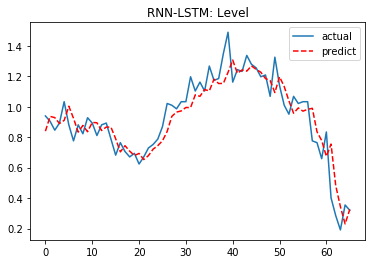

In [471]:
# visualize the result
plt.plot(y_val_single, label="actual")
plt.plot(single_step_model.predict(x_val_single), "r", linestyle='--', label="predict")
plt.legend(loc='best')
plt.title('RNN-LSTM: Level')
plt.savefig("images/elect_all_lstm.png")

print("Test set score: {:.2f}".format(r2_score(y_val_single, single_step_model.predict(x_val_single))))